<h1><b> Stage 1:  Reading data and preparing data for input <b></h1>

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import glob
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import string


from nltk.corpus import stopwords
from collections import defaultdict
from gensim import corpora,models, similarities

from scipy import sparse
import numpy as np

In [2]:
directory = glob.glob('sraa/*')
documents = []
stemmer = PorterStemmer()

for folder in directory:
    print folder + '....',
    tmp = []
    files = glob.glob(folder+"/*")
    nums = 0
    for fileName in files:
        f = open(fileName,'r')
        data = f.read()
        data = ''.join(i if ord(i)<128 else ' ' for i in data )
        data = data.lower()
        
        #toker = RegexpTokenizer(r'((?<=[^\w\s])\w(?=[^\w\s])|(\W))+', gaps=True)
        #dataA = toker.tokenize(data)
        
        dataA = word_tokenize(data)
        dataA_without_punc = [i for i in dataA if i not in string.punctuation]
        
        single = ' '.join([stemmer.stem(w) for w in dataA_without_punc])
        tmp.append(single)
    print 'is created'
    documents.append(tmp)

sraa\realauto.... is created
sraa\realaviation.... is created
sraa\simauto.... is created
sraa\simaviation.... is created


<h1><b> Stage 2:  Preprocessing on data <b></h1>

In [23]:
subDirectory = 'run_sraa'



def preprocess(documents):
    # documents = ['babak is khar','hasan is good']
    stopList = stopwords.words('english')
    print len(stopList)
    texts = [[word for word in document.lower().split() if word not in stopList]#+nontfidf]
         for document in documents]
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    numberOfDocuments = len(documents)
    return [[token for token in text if (frequency[token] > 1 and frequency[token] < numberOfDocuments) ]
        for text in texts]
    
    
    
def makeCorpus(texts):
    # texts = [['babak', 'is' , 'khar'],['hasan', 'is','good']]
    # it means we do some preprocess like: stopword, common word, ...
    dictionary = corpora.Dictionary(texts)
    dictionary.save(subDirectory+'/dictionary.dict')
#     print dictionary.token2id
    return [dictionary.doc2bow(text) for text in texts]


numOfDocs = 0
for docs in documents:
    numOfDocs += len(docs)
classes = np.zeros(numOfDocs,dtype=int)


classLabels = [0,1,2,3]
alldocs = []
idx = 0
classIdx = 0
for docs in documents:
    for doc in docs:
        alldocs.append(doc)
        classes[idx] = classLabels[classIdx]
        idx += 1
    classIdx += 1
        
texts = preprocess(alldocs)
corpus = makeCorpus(texts)
corpora.MmCorpus.serialize(subDirectory+'/corpus.mm', corpus)
np.savetxt(subDirectory + '/classes.dat',classes)



127


<h1>Stage 3: Constructing Feature models</h1>

In [30]:
from gensim.models.ldamodel import LdaModel

corpus = corpora.MmCorpus(subDirectory+'/corpus.mm')
dictionary = corpora.dictionary.Dictionary.load(subDirectory+'/dictionary.dict')
classes = np.loadtxt(subDirectory+'/classes.dat',dtype=int)


ldaModel = LdaModel(corpus, num_topics=30, id2word = dictionary, passes=20)
ldaModel.save(subDirectory+'/lda.model')

tfidfModel = models.TfidfModel(corpus)
tfidfModel.save(subDirectory+'/sraa.tfidf_model')


<h1>Stage 5: Constructing New Representation</h1>

In [33]:
model.num_topics

30

0.811169743218


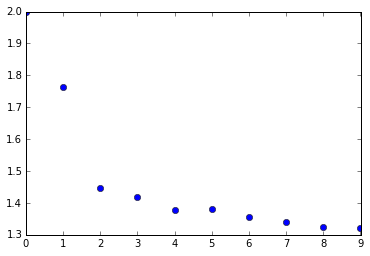

In [19]:
corpus = corpora.MmCorpus(subDirectory+'/all_corpus.mm')
dictionary = corpora.dictionary.Dictionary.load(subDirectory+'/all_dictionary.dict')
classes = np.loadtxt(subDirectory+'/all_classes.dat',dtype=int)
from gensim.models.ldamodel import LdaModel
subDirectory = 'run_sraa'
model = LdaModel.load(subDirectory+'/all_sraa.lda_model')

numFeatures = model.num_topics
numData = len(corpus)
numNodes = numData + numFeatures + 2

sparseData = []
for data in corpus:
    sparseData.append(model[data])

A = sparse.lil_matrix((numNodes,numNodes))

# features: 0-numFeatures
# data: numFeature-(numFeature+numData)
# label: (numFeature+numData), (numFeature+numData+1)
# connect datas to features
for i in range(numData):
    for t in sparseData[i]:
        feature,weight = t[0],t[1]
        A[i+numFeatures,feature] = weight
        A[feature,i+numFeatures] = weight

# connect datas to labels
for i in xrange(numData):
    if classes[i] == 0 or classes[i] == 2:
        A[numData+numFeatures,numFeatures+i] = 1
        A[numFeatures+i,numData+numFeatures] = 1
    else:
        A[numData+numFeatures+1,numFeatures+i] = 1
        A[numFeatures+i,numData+numFeatures+1] = 1

#construct D
N = A.shape[0]
D = sparse.lil_matrix((N,N))
a = A.sum(axis=0)
for i in range(N):
    D[i,i] = a[0,i]
L = D-A
for i in range(numNodes):
    if D[i,i] >-0.0001 and D[i,i] < 0.0001:
        print i, D[i,i]
# generalized eigenvalue decomposition  Lv = tDv
vals, newDataRepresent = sparse.linalg.eigs(L, k=10, M=D)
dataset = pd.DataFrame(newDataRepresent[numFeatures:numFeatures+numData])
X1 = dataset[classes== 0]
X2 = dataset[classes== 1]
X3 = dataset[classes== 2]
X4 = dataset[classes== 3]

Y = pd.Series(classes)

Xtrain = pd.concat([X3,X4])
Y3 = Y[Y==2]
Y4 = Y[Y==3]
Ytrain = pd.concat([Y3,Y4])


from sklearn import svm
clf = svm.LinearSVC()
clf.fit(Xtrain,Ytrain)
Ypred = clf.predict(Xtrain)
print ((Ypred==Ytrain).sum()*1.0)/len(Ytrain)
plt.plot(range(len(vals)),vals,'o')
plt.show()  

c:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:228: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


<h1>Stage 4: Constructing DataFrame</h1>

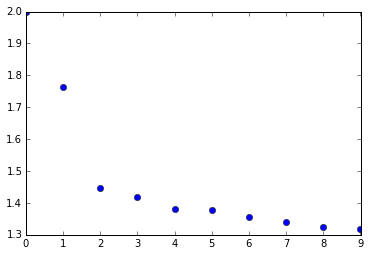

<h1>Stage 6: Learning Models</h1>

0.81116974321752944

<h1> Some Test </h1>

In [10]:
from gensim.models.ldamodel import LdaModel
# ldaModel = LdaModel.load('lda.model')

sparseDataLda = []
ldaFeatureNum = 0
for data in corpus:
    ldaData = ldaModel[data]
    sparseDataLda.append(ldaData)    
    for i in ldaData:
        ldaFeatureNum = max(ldaFeatureNum,i[0])
        
numData = len(corpus)
ldaFeatureNum = 30
dataset = pd.DataFrame(np.zeros((numData,ldaFeatureNum)))

for i in range(numData):
    for t in sparseDataLda[i]:
        dataset[t[0]].ix[i] = t[1]

X1 = dataset[classes== 0]
X2 = dataset[classes== 1]
X3 = dataset[classes== 2]
X4 = dataset[classes== 3]

Y = pd.Series(classes)

Xtrain = pd.concat([X1,X3])
Y1 = Y[Y==0]
Y3 = Y[Y==2]
Ytrain = pd.concat([Y1,Y3])


from sklearn import svm
clf = svm.LinearSVC()
clf.fit(Xtrain,Ytrain)
Ypred = clf.predict(Xtrain)
((Ypred==Ytrain).sum()*1.0)/len(Ytrain)


NameError: name 'ldaModel' is not defined

In [ ]:
train = [
    ('I love this sandwich.', 'pos'),
    ('This is an amazing place!', 'pos'),
    ('I feel very good about these beers.', 'pos'),
    ('This is my best work.', 'pos'),
    ("What an awesome view", 'pos'),
    ('I do not like this restaurant', 'neg'),
    ('I am tired of this stuff.', 'neg'),
    ("I can't deal with this", 'neg'),
    ('He is my sworn enemy!', 'neg'),
    ('My boss is horrible.', 'neg')
]
test = [
    ('The beer was good.', 'pos'),
    ('I do not enjoy my job', 'neg'),
    ("I ain't feeling dandy today.", 'neg'),
    ("I feel amazing!", 'pos'),
    ('Gary is a friend of mine.', 'pos'),
    ("I can't believe I'm doing this.", 'neg')
]

In [ ]:
def save_sparse_matrix(filename, x):
    x_coo = x.tocoo()
    row = x_coo.row
    col = x_coo.col
    data = x_coo.data
    shape = x_coo.shape
    np.savez(filename, row=row, col=col, data=data, shape=shape)

def load_sparse_matrix(filename):
    y = np.load(filename)
    z = sparse.coo_matrix((y['data'], (y['row'], y['col'])), shape=y['shape'])
    return z

save_sparse_matrix('/tmp/my_array',x)
load_sparse_matrix('/tmp/my_array.npz').tolil()